# Evaluate the magic wand model using 10 png test files
Import the needed modules. We use the tflite-micro runtime interpreter for the evaluation.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Tensorflow as well as the tensorflow lite interpreter are imported

In [2]:
import tflite_runtime.interpreter as tflite
import tensorflow as tf

2025-10-20 10:51:35.911428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-20 10:51:35.911606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-20 10:51:35.995551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-20 10:51:36.150291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-20 10:51:37.816818: W tensorflow/compiler/tf2

An tflite interpreter is created and allocate_tensors is called to prepare it for use  
It is provided with the trained model converted to tflite format and quantized in our case

In [3]:
interpreter = tflite.Interpreter(model_path="models/quantized_model.tfl")
interpreter.allocate_tensors() # Needed before execution

The samples used to verify the model are available as png image files  
In order to present them to the model we need one image represented by a matrix of 28x28 pixels 
read_img reads the image from the png file and provides the conversion. This function can be used for any of the sample files

In [4]:
def read_img(img_path):
  """Read magic wand digit image

  Args:
      img_path (str): path to a magic wand digit image

  Returns:
      np.array : image in the correct np.array format
  """
  image = Image.open(img_path)
  data = np.asarray(image, dtype=np.float32)
  if data.shape != (32, 32, 3):
    raise ValueError(
        "Invalid input image shape (MNIST image should have shape 32,32,3)"
    )
  # Model inference requires batch size one
  data = data.reshape((32, 32, 3))
  return data


Let's try to plot the 10 image files

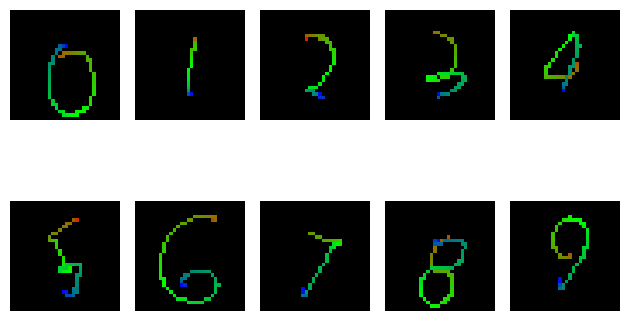

In [5]:
pixel_array = [None]*10
for img in range(10):
    filename = "png_files/digit_{:d}.png".format(img)
    pixel_array[img] = read_img(filename)
    # Normalize the image if necessary
    if pixel_array[img].max() > 1:
        pixel_array[img]= pixel_array[img] / 255.0     

fig, axs = plt.subplots(2,5)
for i in range(2):
    for j in range(5):
        axs[i,j].axis('off')
        axs[i,j].imshow((pixel_array[5*i+j]).reshape(32,32,3))
fig.tight_layout()

get_input details tells us which format is needed at the input of the model

In [6]:
input_details = interpreter.get_input_details()[0]
print(input_details)

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [7]:
data_type = input_details["dtype"]
print("data type: ",data_type)
print("index: ",input_details["index"])
print("shape: ",input_details["shape"])

data type:  <class 'numpy.int8'>
index:  0
shape:  [ 1 32 32  3]


In [8]:
input_quantization_parameters = input_details["quantization_parameters"]
input_scale, input_zero_point = input_quantization_parameters["scales"][0], input_quantization_parameters["zero_points"][0]
print("input scale: {:f}, input_zero_point: {:d}".format(input_scale,input_zero_point))

input scale: 1.000000, input_zero_point: -128


get_output_details informs us about he output format of the data

In [9]:
output_details = interpreter.get_output_details()[0]
print(output_details)
print("\nOutput data type: ",output_details["dtype"])
print("index: ",output_details["index"])
print("shape of output tensor: ",output_details['shape'])

{'name': 'StatefulPartitionedCall:0', 'index': 15, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Output data type:  <class 'numpy.int8'>
index:  15
shape of output tensor:  [ 1 10]


Now we try the whole thing using a single sample file  
First reading the file and converting it to the right format for input to the model

In [10]:
data = read_img("png_files/digit_1.png")

In [13]:
print("min and max in pixel data: {:f}, {:f}".format(data.min(),data.max()))

min and max in pixel data: 0.000000, 255.000000


The pixel values are represented as float values in the range 0..1  
They must be converted to int8 values -128 .. 127

In [15]:
data = (data / input_scale + input_zero_point).astype(data_type)
print("min and max in pixel data after quantization: {:f}, {:f}".format(data.min(),data.max()))

min and max in pixel data after quantization: -128.000000, 127.000000


In [16]:
print(data.shape)
print(data.dtype)

(32, 32, 3)
int8


The input shape must be (1, 32, 32, 3) as we have seen above

In [17]:
# data = data.reshape(1,32,32,3)
# print("New shape: ",data.shape)

We present these data to the input nodes of the model

In [18]:
interpreter.set_tensor(input_details['index'],data.reshape(1,32,32,3))

Invoking the interpreter corresponds to making a prediction for the data based on the trained model

In [20]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index']).reshape(10,)
print("shape of output_data :",output_data.shape)
print(output_data, type(output_data),output_data.dtype)

shape of output_data : (10,)
[-128  127 -128 -128 -128 -128 -128 -128 -128 -128] <class 'numpy.ndarray'> int8


In [21]:
digit = np.argmax(output_data)
print("predicted digit: ",digit)
print(output_data)
probs = [None]*10
print("probabilites: ")
for i in range(10):
    probs[i] = (output_data[i] + 128) / 255
    print("{:6.4f}".format(probs[i]), end=" ")
print("")

predicted digit:  1
[-128  127 -128 -128 -128 -128 -128 -128 -128 -128]
probabilites: 
0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 


To get the probabilities we have to dequantize the result

In [22]:
# dequantize the result
output_quantization_parameters = output_details["quantization_parameters"]
output_scale, output_zero_point = output_quantization_parameters["scales"][0], output_quantization_parameters["zero_points"][0]
print(output_scale * (output_data.astype("float") - output_zero_point))

[0.         0.99609375 0.         0.         0.         0.
 0.         0.         0.         0.        ]


Now that we know how to invoke the interpreter for a single image and how to interpret the result, we can do this for all
10 sample images and calculate the confusion matrix

In [24]:
images = [None] * 10
probabilities = [None] * 10
raw_output_data = [None] * 10
input_details = interpreter.get_input_details()[0]
print("input data type: ", input_details["dtype"])
# get the input quantization parameters and quantize the pixel values
input_quantization_parameters = input_details["quantization_parameters"]
input_scale, input_zero_point = input_quantization_parameters["scales"][0], input_quantization_parameters["zero_points"][0]
print("input scale: {:f}, input_zero_point: {:d}".format(input_scale,input_zero_point))
output_quantization_parameters = output_details["quantization_parameters"]
output_scale, output_zero_point = output_quantization_parameters["scales"][0], output_quantization_parameters["zero_points"][0]
print("output scale: {:f}, output_zero_point: {:d}".format(output_scale,output_zero_point))

for img in range(10):
    # construct the filename
    filename = "png_files/digit_{:d}".format(img) + ".png"
    # print("Filename: ",filename)
    images[img] = read_img(filename)
    if img == 0:
        print("data type of pixels: ",images[img].dtype)
    # quantize the image data
    images[img] = (images[img] / input_scale + input_zero_point).astype(data_type)

    if img == 0:
        print("Data type of pixels passed to the interpreter: ",images[img].dtype)
    if img == 0:
        print("min and max pixel values after quantization: {:f},{:f}".format(images[img].min(),images[img].max()))
    # set the input tensor
    interpreter.set_tensor(input_details['index'],images[img].reshape(1,32,32,3))
    # and invoke inference
    interpreter.invoke()
    output = interpreter.get_tensor(output_details['index']).reshape(10,)
    #if img == 0:
    print(output)
    # dequantize to get the probabilities
    probabilities[img] = output_scale * (output.astype("float") - output_zero_point)
    raw_output_data[img] = output

input data type:  <class 'numpy.int8'>
input scale: 1.000000, input_zero_point: -128
output scale: 0.003906, output_zero_point: -128
data type of pixels:  float32
Data type of pixels passed to the interpreter:  int8
min and max pixel values after quantization: -128.000000,124.000000
[ 127 -128 -128 -128 -128 -128 -128 -128 -128 -128]
[-128  127 -128 -128 -128 -128 -128 -128 -128 -128]
[-120  -28  -39 -123 -128 -128 -123 -122 -127  -85]
[-126 -128  -25    4 -128 -126 -124 -128 -124 -119]
[-126 -127 -128 -128  105 -128 -128 -127 -126 -112]
[-121 -128 -119  -46 -121  -64 -106 -128  -88 -104]
[  -2 -128 -125 -128 -128 -128  -16 -128 -114 -128]
[-125 -125 -128 -125 -127 -128 -128  107 -128 -118]
[ -51 -128 -128 -128 -128 -128 -127 -128   51 -128]
[-110 -107 -126 -127 -128 -128 -128 -122 -127   79]


In [25]:
print("The confusion matrix:")
for i in range(10):
    for j in range(10):
        print("{:8.6f}".format(probabilities[i][j]), end=" ")
    print("")

The confusion matrix:
0.996094 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.996094 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.031250 0.390625 0.347656 0.019531 0.000000 0.000000 0.019531 0.023438 0.003906 0.167969 
0.007812 0.000000 0.402344 0.515625 0.000000 0.007812 0.015625 0.000000 0.015625 0.035156 
0.007812 0.003906 0.000000 0.000000 0.910156 0.000000 0.000000 0.003906 0.007812 0.062500 
0.027344 0.000000 0.035156 0.320312 0.027344 0.250000 0.085938 0.000000 0.156250 0.093750 
0.492188 0.000000 0.011719 0.000000 0.000000 0.000000 0.437500 0.000000 0.054688 0.000000 
0.011719 0.011719 0.000000 0.011719 0.003906 0.000000 0.000000 0.917969 0.000000 0.039062 
0.300781 0.000000 0.000000 0.000000 0.000000 0.000000 0.003906 0.000000 0.699219 0.000000 
0.070312 0.082031 0.007812 0.003906 0.000000 0.000000 0.000000 0.023438 0.003906 0.808594 


In [26]:
for i in range(10):
    print("Digits predicted: {:d}".format(probabilities[i].argmax()))

Digits predicted: 0
Digits predicted: 1
Digits predicted: 1
Digits predicted: 3
Digits predicted: 4
Digits predicted: 3
Digits predicted: 0
Digits predicted: 7
Digits predicted: 8
Digits predicted: 9


Try to improve probabilities

In [ ]:
probs = [None]*10
for img in range(10):
    probs[img] = raw_output_data[img].astype(float)
    for i in range(10):        
        probs[img][i] = (raw_output_data[img][i] + 128) / 255
        print("{:8.6f}".format(probs[img][i]),end=" ")
    print("")

check if probabilities sum to 1.0

In [ ]:
for img in range(10):
    sum = 0
    for i in range(10):
        sum += probabilities[img][i]
    print("sum of probabilities for digit {:d}: {:8.2f}".format(img,sum))

In [ ]:
for img in range(10):
    sum = 0
    for i in range(10):
        sum += probs[img][i]
    print("sum of probabilities for digit {:d} for custom dequantization: {:8.2f}".format(img,sum))

Plot the confusion matrix

In [ ]:
from matplotlib import colors as colors
plt.matshow(probs,cmap="viridis")

The values are either vefy close to 1 or very small. We therefore only see the diagonal of the confusion matrix.  
If we want to see the examples, where the probability to have found the right digit is less than 1, then we must use a log scale

In [ ]:
from matplotlib import colors as colors
plt.matshow(probs,norm=colors.LogNorm(0.001,1), cmap="viridis")